In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
import random as rndm

from IPython.display import clear_output

In [54]:
# Preproceso de datos

df = pd.read_csv('datablow.csv');
# Quitamos la columna que no nos sirve
df = df.drop(columns=['Unnamed: 0'])
df.columns = ['feature 1', 'feature 2']
df['Cluster'] = 0
df['Dist_To_Cluster'] = np.inf
df.head()

,feature 1,feature 2,Cluster,Dist_To_Cluster
0,0.599449,0.143441,0,inf
1,0.699177,0.107459,0,inf
2,0.560343,0.185676,0,inf
3,0.562573,0.089642,0,inf
4,0.084258,0.832261,0,inf


In [55]:
# K-Medoids
# Algoritmo extraído de https://www.codingninjas.com/codestudio/library/k-medoids-algorithm

# 1. Randomly select k points from the data to form k clusters. These are the initial medioids.

def get_random_points_df(df, k):
    return (df.sample(n=k, replace=False)).drop(columns=['Dist_To_Cluster'])

In [56]:
# 2. The distances between the medoid points and the non-medoid points are calculated, and each point is assigned to the cluster of its nearest medoid

# La lógica de la implementación es análoga a KMeans
# La diferencia radica en que aprovechando la estructura de datos DataFrame
# se calcula de jalón la distancia de cada punto a su centroide y se guarda en una columna 
# para calcular la función de costo de forma sencilla.

def assign_cluster_df(df, k, centroids_df, norm=np.linalg.norm):
    df_cluster = df.copy()
    centroids_np = centroids_df[['feature 1', 'feature 2']].to_numpy()
    for index, row in df_cluster[['feature 1', 'feature 2']].iterrows():
        point = np.array(row)
        min_dist = np.inf
        cluster_indx = -1

        for i in range(k):
            distance = norm(point - centroids_np[i])
            if distance < min_dist:
                min_dist = distance
                cluster_indx = i
        
        df_cluster.at[index, 'Cluster'] = cluster_indx
        df_cluster.at[index, 'Dist_To_Cluster'] = min_dist
    return df_cluster


In [57]:
# 3. Calculate the cost as the total sum of the distances (dissimilarities) of the data points from the assigned medoid.
def compute_cost(clusters):
    return clusters.groupby(['Cluster'])['Dist_To_Cluster'].sum().sum()

In [68]:
#def plot_clusters(clusters, labels, centroids, iteration, frob_norm, centroid_colors):
def plot_clusters(clusters, labels, centroids, k, centroid_colors):
    data_2d = clusters[['feature 1', 'feature 2']].to_numpy()
    centroids_2d = centroids.to_numpy()
    clear_output(wait=True)
    #plt.suptitle(f'Iteración: {iteration}')
    #plt.title(f'Norma Frobenius: {frob_norm}')
    plt.title(f'K-Medoids con k={k}')
    
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], c=centroid_colors, marker='x', s=100)

    plt.show()

In [69]:
#def plot_voronoi(clusters, labels, centroids, iteration, frob_norm, centroid_colors):
def plot_voronoi(clusters, labels, centroids, k, centroid_colors):

    data_2d = clusters[['feature 1', 'feature 2']].to_numpy()
    centroids_2d = centroids[['feature 1', 'feature 2']].to_numpy()
    clear_output(wait=True)
    vor = Voronoi(centroids_2d)
    voronoi_plot = voronoi_plot_2d(vor)
    #plt.suptitle(f'Iteración: {iteration}')
    #plt.title(f'Norma Frobenius: {frob_norm}')
    plt.title(f'K-Medoids con k={k}')
    
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], c=centroid_colors, marker='x', s=100)

    plt.show()

In [70]:
# 4. Swap one medoid point with a non-medoid point from the same cluster as the medoid point and recalculate the cost.

def KMedoids(data, k, norm=np.linalg.norm, scatter_plot = False, voronoi_plot = False):

    # Obtenemos medoids de forma aleatoria
    medoids = get_random_points_df(data, k)
    
    # Para cada medoid asignamos a cada punto del dataset su cluster en función de su distancia
    # al medoid que representa dicho cluster. 
    clusters = assign_cluster_df(data, k, medoids, norm=norm)
    
    # Localizamos dentro del conjunto de datos con cada punto ya asignado su cluster
    # los nuevos medoids
    medoids = clusters.iloc[medoids.index]

    # Calculamos la función de costo.
    previous_cost = compute_cost(clusters)

    test_cost = np.inf

    iteration = 1

    # Si en la iteración anterior y la nueva no ha ocurrido mejora
    # el algoritmo converge, en otro caso repetimos
    while test_cost < previous_cost:
        previous_cost = test_cost

        medoids = swapped_medoids

        clusters = test_clusters

        # Para un medoid aleatorio ya asignado...
        cluster_idx = rndm.choice(range(k))

        # obtenemos candidatos a remplazar el medoid dentro del cluster que lo representa
        new_medoid_candidates = clusters.groupby('Cluster').sample(n=1).set_index('Cluster')

        curr_candidate = new_medoid_candidates.iloc[[cluster_idx]]

        # Intercambiamos el candidato actual por el escogido de forma aleatoria
        swapped_medoids = medoids.copy().set_index('Cluster')

        swapped_medoids.update(curr_candidate)

        # Observamos si el costo es mejor al intercambiar el medoid por el candidato
        test_clusters = assign_cluster_df(data, k, swapped_medoids, norm=norm)

        test_cost = compute_cost(test_clusters)
        
        iteration += 1
     
    
    return (medoids, clusters)



In [71]:
data = df
k = 6
norm = np.linalg.norm

medoids, clusters = KMedoids(data, k, norm, scatter_plot=True)

medoids

,feature 1,feature 2,Cluster,Dist_To_Cluster
695,1.091667,0.571234,0,0.0
717,0.075084,0.772352,1,0.0
949,1.136428,0.680835,2,0.0
163,0.443947,0.042770,3,0.0
329,0.465670,0.029553,4,0.0
118,0.478159,0.021145,5,0.0


In [72]:
if len(medoids.merge(clusters)) == len(medoids):
    print(
        "Como la intersección de los dataframes es el dataframe de los medoids, entonces los medoids en efecto pertenecen a sus clusters y al dataset"
    )

Como la intersección de los dataframes es el dataframe de los medoids, entonces los medoids en efecto pertenecen a sus clusters y al dataset


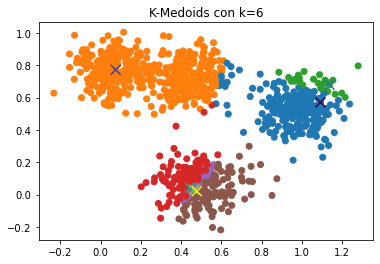

In [73]:
plot_clusters(
    clusters, 
    clusters['Cluster'].map({i : f'C{i}' for i in range(k)}), 
    medoids, 
    k,
    [i+1 for i in range(k)]
)

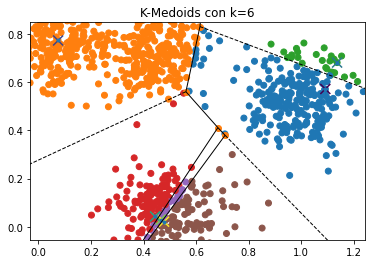

In [74]:
plot_voronoi(
    clusters, 
    clusters['Cluster'].map({i : f'C{i}' for i in range(k)}), 
    medoids, 
    k,
    [i+1 for i in range(k)]
)